In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd "drive/MyDrive/Colab Notebooks/VinBrain_Intern/W1/3. Tracking: Run code SORT/"

/content/drive/My Drive/Colab Notebooks/VinBrain_Intern/W1/3. Tracking: Run code SORT


In [ ]:
# Download dataset in MOT challenge
!wget "https://motchallenge.net/data/MOT17Det.zip"

--2021-05-11 00:54:15--  https://motchallenge.net/data/MOT17Det.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1952547113 (1.8G) [application/zip]
Saving to: ‘MOT17Det.zip’

MOT17Det.zip        100%[===================>]   1.82G  20.4MB/s    in 2m 35s  

2021-05-11 00:56:51 (12.0 MB/s) - ‘MOT17Det.zip’ saved [1952547113/1952547113]



In [ ]:
!unzip "MOT17Det.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/MOT17-02/img1/000323.jpg  
  inflating: train/MOT17-02/img1/000324.jpg  
  inflating: train/MOT17-02/img1/000325.jpg  
  inflating: train/MOT17-02/img1/000326.jpg  
  inflating: train/MOT17-02/img1/000327.jpg  
  inflating: train/MOT17-02/img1/000328.jpg  
  inflating: train/MOT17-02/img1/000329.jpg  
  inflating: train/MOT17-02/img1/000330.jpg  
  inflating: train/MOT17-02/img1/000331.jpg  
  inflating: train/MOT17-02/img1/000332.jpg  
  inflating: train/MOT17-02/img1/000333.jpg  
  inflating: train/MOT17-02/img1/000334.jpg  
  inflating: train/MOT17-02/img1/000335.jpg  
  inflating: train/MOT17-02/img1/000336.jpg  
  inflating: train/MOT17-02/img1/000337.jpg  
  inflating: train/MOT17-02/img1/000338.jpg  
  inflating: train/MOT17-02/img1/000339.jpg  
  inflating: train/MOT17-02/img1/000340.jpg  
  inflating: train/MOT17-02/img1/000341.jpg  
  inflating: train/MOT17-02/img1/000342.jpg  
  inflating: train/MOT17-02/i

In [22]:
# Import library
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

import cv2

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [19]:
def make_datapath_list():
    root_path = "./train/MOT17-02/img1/"
    target_path = osp.join(root_path + "/*.jpg")
    path_list = []  
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [20]:
list_img_path = make_datapath_list()
len(list_img_path)

600

In [21]:
list_img_path[0]

'./train/MOT17-02/img1/000001.jpg'

In [23]:
# demo show image using cv2
# 1. read image by using openCV (method imread)
img_sample = cv2.imread(list_img_path[0])
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB) # img_sample now is a 3-D array

In [28]:
img_tensor = torch.tensor(img_sample)
img_tensor.size()

torch.Size([1080, 1920, 3])

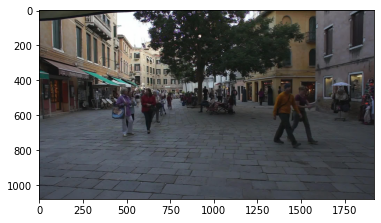

In [30]:
# 2. Display image using matplotlib
plt.imshow(img_sample)
plt.show()

In [42]:
def read_convert_img_toTensor(img_path):
  img_sample = cv2.imread(img_path)
  img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
  img_tensor = torch.tensor(img_sample)
  img_tensor = img_tensor / 255.0
  return img_tensor.view(img_tensor.size(2), img_tensor.size(0), img_tensor.size(1))

In [37]:
#Test 
read_convert_img_toTensor(list_img_path[3]).size()

torch.Size([3, 1080, 1920])

In [38]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [50]:
#demo object detection using FasterRCNN
net = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
net.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [51]:
# Demo
input = read_convert_img_toTensor(list_img_path[0])
prediction = net([input])
prediction

[{'boxes': tensor([[ 756.2275,  263.2236,  899.7243,  647.9937],
          [ 794.0911,  266.0682,  897.5511,  525.1174],
          [ 720.2001,  344.9475,  873.6011,  585.2839],
          [ 889.6436,  251.2972, 1009.4026,  625.9145],
          [ 734.3239,  337.7621,  831.2574,  534.0779],
          [ 849.6856,  225.6024, 1072.5494,  639.7650],
          [ 742.8693,  237.6192, 1191.5782,  656.3066],
          [ 711.5016,  421.5345,  869.9579,  489.7242],
          [ 804.5496,  297.3037,  893.7932,  440.6160],
          [ 714.6296,  419.6058,  866.6912,  492.2953],
          [ 672.6635,  205.2018, 1014.4863,  640.6087]], grad_fn=<StackBackward>),
  'labels': tensor([ 1,  1,  1,  1,  1,  1,  1, 15,  1, 62,  1]),
  'scores': tensor([0.6217, 0.4460, 0.3966, 0.3079, 0.2926, 0.2036, 0.1940, 0.0589, 0.0585,
          0.0581, 0.0510], grad_fn=<IndexBackward>)}]

In [63]:
prediction_class_total = []
prediction_bbox_total = []
prediction_score = []
for each_result in prediction:
  labels_index = each_result["labels"].numpy()
  candidate = []
  for each_index in labels_index:
    candidate.append(COCO_INSTANCE_CATEGORY_NAMES[each_index])
  prediction_class_total.append(candidate)
  bbox_candidate = list(each_result["boxes"].detach().numpy())
  bbox_candidate_modify = [list(ele) for ele in bbox_candidate]
  scores_candidate = list(each_result["scores"].detach().numpy())
  prediction_bbox_total.append(bbox_candidate_modify)
  prediction_score.append(scores_candidate)

In [64]:
print(prediction_class_total)
print(prediction_bbox_total)
print(prediction_score)

[['person', 'person', 'person', 'person', 'person', 'person', 'person', 'bench', 'person', 'chair', 'person']]
[[[756.22754, 263.2236, 899.7243, 647.99365], [794.0911, 266.0682, 897.5511, 525.1174], [720.2001, 344.94754, 873.6011, 585.28394], [889.64355, 251.29716, 1009.40265, 625.9145], [734.3239, 337.76205, 831.25745, 534.0779], [849.6856, 225.60245, 1072.5494, 639.765], [742.8693, 237.61916, 1191.5782, 656.30664], [711.50165, 421.53455, 869.95795, 489.72415], [804.54956, 297.3037, 893.79315, 440.61603], [714.6296, 419.6058, 866.69116, 492.29535], [672.6635, 205.20184, 1014.48627, 640.6087]]]
[[0.6216813, 0.4460281, 0.3966044, 0.3078988, 0.29256856, 0.20358175, 0.19396183, 0.058895446, 0.058546174, 0.058083303, 0.051040944]]


In [66]:
img = cv2.imread(list_img_path[0]) # Read image with cv2
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

In [89]:
boxes = prediction_bbox_total[0]
for i in range(len(boxes)):
  cv2.rectangle(img, 
                (boxes[i][0], boxes[i][2]), # Start point 
                (boxes[i][1], boxes[i][3]), # End point
                color = (0, 255, 0), 
                thickness = 3)
  cv2.putText(img, 
              prediction_class_total[0][i], 
              (boxes[i][0], boxes[i][2]),  
              cv2.FONT_HERSHEY_SIMPLEX, 
              1.5, 
              (0, 255, 0),
              1,
              3)

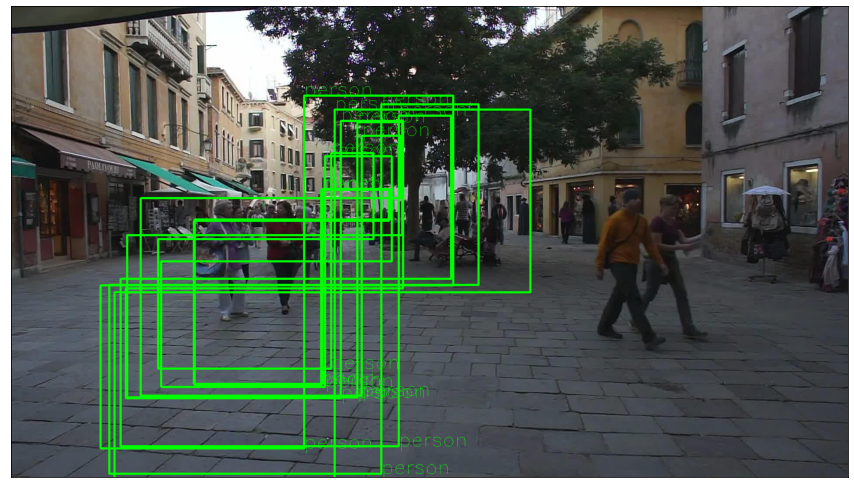

In [90]:
plt.figure(figsize=(15,20)) # display the output image
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
def detect_object_in_img(net, img_path):
  input = read_convert_img_toTensor(img_path)
  prediction = net([img])

In [91]:
!git clone https://github.com/abewley/sort.git

Cloning into 'sort'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 202 (delta 0), reused 1 (delta 0), pack-reused 198
Receiving objects: 100% (202/202), 1.21 MiB | 7.09 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [92]:
cd "sort/"

/content/drive/My Drive/Colab Notebooks/VinBrain_Intern/W1/3. Tracking: Run code SORT/sort


In [93]:
pip install -r requirements.txt

     |████████████████████████████████| 184kB 19.8MB/s 
     |████████████████████████████████| 12.5MB 25.6MB/s 
     |████████████████████████████████| 1.5MB 36.4MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp37-none-any.whl size=110452 sha256=dac32cb909f4ce336613a237ca4936a3993b494c5ee1a68847c43f54dbc4439f
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590137 sha256=cfaff5fddf993aeb685cee430ba66b696f3161e0c2de746ff70cda8fc0ad36a5
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built filterpy lap
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [97]:
!git clone https://github.com/mlvlab/COSE474.git

Cloning into 'COSE474'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 186 (delta 43), reused 15 (delta 7), pack-reused 106
Receiving objects: 100% (186/186), 44.61 MiB | 13.85 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [107]:
import json
import collections
from pprint import pprint

In [99]:
with open("./COSE474/3_MOT_detinfo.json") as data_file:    
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

In [100]:
pprint(odata)

Streaming output truncated to the last 5000 lines.
                'scores': 0.9063880443572998},
               {'bbox': [34.13352966308594,
                         355.93682861328125,
                         85.53865051269531,
                         401.1189270019531],
                'labels': 68,
                'scores': 0.8869121670722961},
               {'bbox': [1317.8665771484375,
                         566.4204711914062,
                         1369.163818359375,
                         642.6348266601562],
                'labels': 27,
                'scores': 0.8799705505371094},
               {'bbox': [1227.9986572265625,
                         579.244873046875,
                         1272.51025390625,
                         648.2922973632812],
                'labels': 27,
                'scores': 0.7431402206420898}]),
             ('000459.jpg',
              [{'bbox': [76.42948150634766,
                         150.27622985839844,
                    

In [114]:
for key in odata.keys():   
    arrlist = []
    print(key)
    det_img = cv2.imread("./train/MOT17-09/img1/" + key)
    det_result = data[key] 
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox + [scores]
        arrlist.append(templist)
    print(arrlist)

000001.jpg
[[1698.7020263671875, 385.6827087402344, 1865.2003173828125, 732.7584838867188, 0.9986282587051392], [0.0, 342.8795166015625, 119.72566986083984, 904.257568359375, 0.9959816932678223], [1252.117431640625, 540.7969360351562, 1304.28076171875, 652.4344482421875, 0.9941657781600952], [1289.6956787109375, 464.5318603515625, 1353.03076171875, 654.7779541015625, 0.9911497831344604], [251.6560821533203, 456.1808776855469, 350.5169677734375, 708.0685424804688, 0.9878689646720886], [860.8873291015625, 518.4471435546875, 899.9940185546875, 626.6289672851562, 0.976700484752655], [1786.870361328125, 458.9705810546875, 1875.1800537109375, 573.8833618164062, 0.9591391682624817], [1882.5340576171875, 389.7092590332031, 1917.815185546875, 572.8724365234375, 0.9382187128067017], [119.08243560791016, 503.63409423828125, 194.78839111328125, 740.2471313476562, 0.9372360110282898], [1242.462646484375, 363.9165954589844, 1343.780029296875, 469.2237243652344, 0.8739478588104248], [46.3128433227539

In [145]:
import os 
from os.path import join

In [165]:
root = 'drive/MyDrive/Colab Notebooks/VinBrain_Intern/W1/3. Tracking: Run code SORT/'
sort = join(root,'sort/')
sys.path.append("/content/drive/MyDrive/Colab Notebooks/VinBrain_Intern/W1/3. Tracking: Run code SORT/sort/sort.py")

In [174]:
from sort import sort

In [177]:
tracker = sort.Sort()

In [178]:
total = []
for key in odata.keys():   
    arrlist = []
    print(key)
    det_img = cv2.imread("./train/MOT17-09/img1/" + key)
    det_result = data[key] 
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox + [scores]
        arrlist.append(templist)
    total.append(arrlist)

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000013.jpg
000014.jpg
000015.jpg
000016.jpg
000017.jpg
000018.jpg
000019.jpg
000020.jpg
000021.jpg
000022.jpg
000023.jpg
000024.jpg
000025.jpg
000026.jpg
000027.jpg
000028.jpg
000029.jpg
000030.jpg
000031.jpg
000032.jpg
000033.jpg
000034.jpg
000035.jpg
000036.jpg
000037.jpg
000038.jpg
000039.jpg
000040.jpg
000041.jpg
000042.jpg
000043.jpg
000044.jpg
000045.jpg
000046.jpg
000047.jpg
000048.jpg
000049.jpg
000050.jpg
000051.jpg
000052.jpg
000053.jpg
000054.jpg
000055.jpg
000056.jpg
000057.jpg
000058.jpg
000059.jpg
000060.jpg
000061.jpg
000062.jpg
000063.jpg
000064.jpg
000065.jpg
000066.jpg
000067.jpg
000068.jpg
000069.jpg
000070.jpg
000071.jpg
000072.jpg
000073.jpg
000074.jpg
000075.jpg
000076.jpg
000077.jpg
000078.jpg
000079.jpg
000080.jpg
000081.jpg
000082.jpg
000083.jpg
000084.jpg
000085.jpg
000086.jpg
000087.jpg
000088.jpg
000089.jpg
000090.jpg
000091.jpg

In [179]:
len(total)

525

In [196]:
one_sample = total[321]
print(np.array(one_sample).shape)
track_bbs_ids = tracker.update(np.array(one_sample))
track_bbs_ids.shape

(12, 5)


(12, 5)

In [197]:
print(track_bbs_ids)

[[1.88315039e+03 4.38242493e+02 1.91757654e+03 6.00539917e+02
  1.20000000e+01]
 [1.59220707e+00 3.42216827e+02 2.50280823e+02 4.43415070e+02
  1.10000000e+01]
 [1.15374707e+03 5.12564636e+02 1.19779834e+03 5.98353760e+02
  1.00000000e+01]
 [1.42455750e+03 3.78478180e+02 1.50080286e+03 6.82110840e+02
  9.00000000e+00]
 [1.25056480e+02 5.35693298e+02 1.93649963e+02 7.39470276e+02
  8.00000000e+00]
 [1.67025403e+03 4.00086090e+02 1.77981946e+03 5.89506653e+02
  7.00000000e+00]
 [1.68576477e+03 5.28962952e+02 1.77442493e+03 7.27060364e+02
  6.00000000e+00]
 [1.58474561e+03 4.47109833e+02 1.67844324e+03 6.97751221e+02
  5.00000000e+00]
 [1.32691675e+03 3.66553345e+02 1.43052441e+03 7.17513123e+02
  4.00000000e+00]
 [1.17830469e+03 4.05892426e+02 1.27202930e+03 7.16735229e+02
  3.00000000e+00]
 [1.24644141e+03 3.82376526e+02 1.36443152e+03 7.43471985e+02
  2.00000000e+00]
 [1.45602380e+03 3.72809906e+02 1.60506128e+03 7.46377747e+02
  1.00000000e+00]]


In [198]:
one_sample = total[322]
print(np.array(one_sample).shape)
track_bbs_ids = tracker.update(np.array(one_sample))
track_bbs_ids.shape

(12, 5)


(12, 5)

In [199]:
track_bbs_ids

array([[1.88197002e+03, 4.38230823e+02, 1.91714525e+03, 6.00448205e+02,
        1.20000000e+01],
       [9.82724184e-02, 3.42246829e+02, 2.40086831e+02, 4.41199542e+02,
        1.10000000e+01],
       [1.15312324e+03, 5.14541915e+02, 1.19604488e+03, 5.99196519e+02,
        1.00000000e+01],
       [1.42674582e+03, 3.81727551e+02, 1.50122555e+03, 6.84016223e+02,
        9.00000000e+00],
       [1.27605387e+02, 5.35637643e+02, 1.97101511e+02, 7.39748995e+02,
        8.00000000e+00],
       [1.67091039e+03, 4.00521704e+02, 1.77865737e+03, 5.89580247e+02,
        7.00000000e+00],
       [1.68310869e+03, 5.27127021e+02, 1.77293807e+03, 7.26192620e+02,
        6.00000000e+00],
       [1.58497674e+03, 4.46240097e+02, 1.67836816e+03, 6.97110784e+02,
        5.00000000e+00],
       [1.32884349e+03, 3.65922181e+02, 1.43392320e+03, 7.20030393e+02,
        4.00000000e+00],
       [1.17739437e+03, 4.05392361e+02, 1.27258506e+03, 7.18096617e+02,
        3.00000000e+00],
       [1.24875937e+03, 3.8201

In [ ]:
track_bbs_ids = mot_tracker.update(np.array(one_sample))
    
mot_imgid = key.replace('.jpg','')
newname = save_path + mot_imgid + '_mot.jpg'
print(mot_imgid)

for j in range(track_bbs_ids.shape[0]):  
    ele = track_bbs_ids[j, :]
    x = int(ele[0])
    y = int(ele[1])
    x2 = int(ele[2])
    y2 = int(ele[3])
    track_label = str(int(ele[4])) 
    cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
    cv2.putText(det_img, '#' + track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
    
cv2.imwrite(newname,det_img)